<a href="https://colab.research.google.com/github/duonghung86/Vehicle-trajectory-tracking/blob/master/Codes/VTP_1_04_Summary_of_simple_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All step-by-step LSTM models for vehicle trajectory prediction
---

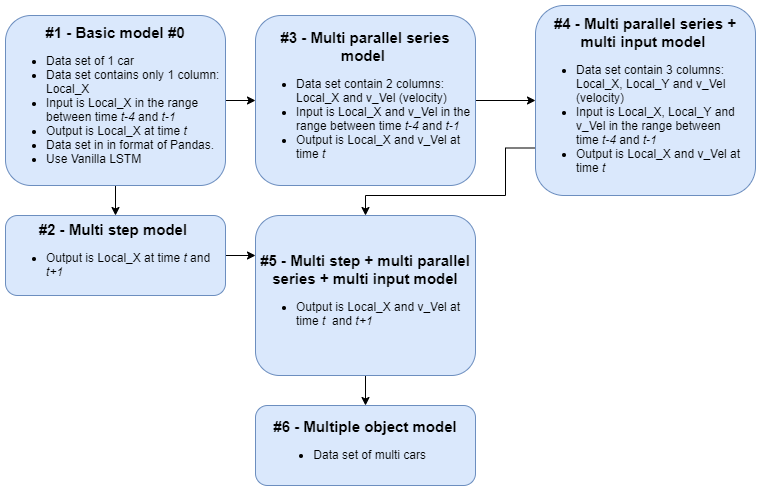

Overview on the configuration of all simple models

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 1|Baseline model with multi input time steps|1|1|1|0|**4**|1| 
Model 2|Add multi output time steps|1|1|1|0|4|**2**|
Model 3|Add multi input series|1|**2**|1|0|4|2|
Model 4|Add multi `output` series|1|2|**2**|0|4|2|
Model 5|Add multi constant input|1|2|2|**2**|4|2|
Model 6|Add more objects|**4**|2|2|2|4|2|


## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

plt.rcParams['figure.figsize'] = (8, 6)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load dataset

In [2]:
url_1 = 'https://github.com/duonghung86/Vehicle-trajectory-tracking/raw/master/Data/NGSIM/0750_0805_us101_smoothed_11_.zip'
zip_path = tf.keras.utils.get_file(origin=url_1, fname=url_1.split('/')[-1], extract=True)
csv_path = zip_path.replace('zip','csv')
csv_path

59645952/59637793 [==============================] - 1s 0us/step


'/root/.keras/datasets/0750_0805_us101_smoothed_11_.csv'

Let's take a glance at the data. Here are the first few rows:

In [3]:
df = pd.read_csv(csv_path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vehicle_ID    1048575 non-null  int64  
 1   Frame_ID      1048575 non-null  int64  
 2   Total_Frames  1048575 non-null  int64  
 3   Global_Time   1048575 non-null  int64  
 4   Local_X       1048575 non-null  float64
 5   Local_Y       1048575 non-null  float64
 6   Global_X      1048575 non-null  float64
 7   Global_Y      1048575 non-null  float64
 8   v_Length      1048575 non-null  float64
 9   v_Width       1048575 non-null  float64
 10  v_Class       1048575 non-null  int64  
 11  v_Vel         1048575 non-null  float64
 12  v_Acc         1048575 non-null  float64
 13  Lane_ID       1048575 non-null  int64  
 14  Preceeding    1048575 non-null  int64  
 15  Following     1048575 non-null  int64  
 16  Space_Hdwy    1048575 non-null  float64
 17  Time_Hdwy     1048575 non-n

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,2,13,437,1118846980200,16.467196,35.380427,6451137.641,1873344.962,14.5,4.9,2,40.000000,0.000000,2,0,0,0.0,0.0
1,2,14,437,1118846980300,16.446594,39.381608,6451140.329,1873342.000,14.5,4.9,2,40.012349,0.123485,2,0,0,0.0,0.0
2,2,15,437,1118846980400,16.425991,43.381541,6451143.018,1873339.038,14.5,4.9,2,39.999855,-0.124939,2,0,0,0.0,0.0
3,2,16,437,1118846980500,16.405392,47.380780,6451145.706,1873336.077,14.5,4.9,2,39.992920,-0.069349,2,0,0,0.0,0.0
4,2,17,437,1118846980600,16.384804,51.379881,6451148.395,1873333.115,14.5,4.9,2,39.991544,-0.013759,2,0,0,0.0,0.0


Next look at the statistics of the dataset:

In [4]:
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
Vehicle_ID,1048575.0,1.533080e+03,790.271,2.000000e+00,9.320000e+02,1.574000e+03,2.210000e+03,2.783000e+03
Frame_ID,1048575.0,4.518249e+03,2412.479,8.000000e+00,2.455000e+03,4.586000e+03,6.598000e+03,8.906000e+03
Total_Frames,1048575.0,5.608770e+02,146.577,1.770000e+02,4.640000e+02,5.180000e+02,6.400000e+02,1.010000e+03
Global_Time,1048575.0,1.118847e+12,241247.914,1.118847e+12,1.118847e+12,1.118847e+12,1.118848e+12,1.118848e+12
Local_X,1048575.0,2.940600e+01,16.666,5.340000e-01,1.728400e+01,2.955700e+01,4.187500e+01,7.347800e+01
Local_Y,1048575.0,1.002056e+03,596.357,1.796600e+01,4.883960e+02,9.640280e+02,1.491548e+03,2.195470e+03
Global_X,1048575.0,6.451838e+06,446.275,6.451107e+06,6.451450e+06,6.451808e+06,6.452205e+06,6.452734e+06
Global_Y,1048575.0,1.872677e+06,397.006,1.871875e+06,1.872352e+06,1.872699e+06,1.873015e+06,1.873365e+06
v_Length,1048575.0,1.463500e+01,4.870,4.000000e+00,1.200000e+01,1.450000e+01,1.650000e+01,7.610000e+01
v_Width,1048575.0,6.132000e+00,1.037,2.000000e+00,5.400000e+00,6.000000e+00,6.900000e+00,8.500000e+00


In [5]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'Preceeding', 'Following', 'Space_Hdwy',
       'Time_Hdwy'],
      dtype='object')

In [6]:
#  keep only columns that are useful for now
kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID']
df = df[kept_cols]
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
0,2,13,437,16.467196,35.380427,14.5,4.9,2,40.000000,0.000000,2
1,2,14,437,16.446594,39.381608,14.5,4.9,2,40.012349,0.123485,2
2,2,15,437,16.425991,43.381541,14.5,4.9,2,39.999855,-0.124939,2
3,2,16,437,16.405392,47.380780,14.5,4.9,2,39.992920,-0.069349,2
4,2,17,437,16.384804,51.379881,14.5,4.9,2,39.991544,-0.013759,2


In [7]:
'the number of vehicles is {}'.format(len(df.Vehicle_ID.unique()))

'the number of vehicles is 1993'

# Model 1

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 1|Baseline model with multi input time steps|1|1|1|0|**4**|1| 

## Data preparation

In [8]:
# Let pick the vehicle that had longest historical data
max_frames = df.Total_Frames.max()
print(max_frames)
car_id = df[df.Total_Frames==max_frames].Vehicle_ID.unique()
"ID of the car that have longest data is {} ".format(car_id[0])

1010


'ID of the car that have longest data is 2582 '

In [9]:
simple_df = df[df.Vehicle_ID==car_id[0]].copy()
simple_df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID
932102,2582,7263,1010,4.725434,36.935259,18.5,6.9,2,45.030000,0.000000,1
932103,2582,7264,1010,4.694650,41.384189,18.5,6.9,2,44.490366,-5.396343,1
932104,2582,7265,1010,4.668727,45.875960,18.5,6.9,2,44.918464,4.280980,1
932105,2582,7266,1010,4.646575,50.394698,18.5,6.9,2,45.187921,2.694570,1
932106,2582,7267,1010,4.627103,54.924527,18.5,6.9,2,45.298705,1.107846,1


### series2seq1: Function that return sequence input and output| Version 1

**Arguments**:

- data: Sequence of observations as a list or NumPy array.
- n_in: Number of lag observations as input (X).
- n_out: Number of observations as output (y).
- dropnan: Boolean whether or not to drop rows with NaN values.
    
**Returns**:
- X: Feature Pandas DataFrame
- y: Label Pandas dataframe

  

In [10]:
def series2seq1(data, n_in=1, n_out=1, dropnan=True):

    dat = data.copy()

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dat.shift(i))
        names += ['{}(t-{})'.format(dat.name, i) ]

    # forecast sequence (t, t+1, ... t+n) for selected labels
    for i in range(0, n_out):
        cols.append(dat.shift(-i))
        if i == 0:
            names += ['{}(t)'.format(dat.name)]
        else:
            names += ['{}(t+{})'.format(dat.name, i)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    X = agg.iloc[:,:n_in]
    y = agg.iloc[:,n_in:].copy()
    return X, y
  
# Test the function
X, y = series2seq1(df.Local_X, n_in=2, n_out=1, dropnan=False)
print(X.head())
print(y.head())

   Local_X(t-2)  Local_X(t-1)
0           NaN           NaN
1           NaN     16.467196
2     16.467196     16.446594
3     16.446594     16.425991
4     16.425991     16.405392
   Local_X(t)
0   16.467196
1   16.446594
2   16.425991
3   16.405392
4   16.384804


In [11]:
n_steps = 4
n_labels = 1
n_future = 1
n_features = 1

In [12]:
X, y = series2seq1(simple_df.Local_X, n_in=n_steps, n_out=n_future, dropnan=True)
print(X.head(), X.shape)
print(y.head(), y.shape)

        Local_X(t-4)  Local_X(t-3)  Local_X(t-2)  Local_X(t-1)
932106      4.725434      4.694650      4.668727      4.646575
932107      4.694650      4.668727      4.646575      4.627103
932108      4.668727      4.646575      4.627103      4.609221
932109      4.646575      4.627103      4.609221      4.591890
932110      4.627103      4.609221      4.591890      4.571389 (1006, 4)
        Local_X(t)
932106    4.627103
932107    4.609221
932108    4.591890
932109    4.571389
932110    4.543895 (1006, 1)


### Split the data set


In [13]:
### Split the data set
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(704, 4) (302, 4) (704, 1) (302, 1)


In [15]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(704, 4)


,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1)
count,7.040000e+02,7.040000e+02,7.040000e+02,7.040000e+02
mean,-2.775558e-17,-1.196328e-15,3.258126e-16,8.500145e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.576153e+00,-1.579742e+00,-1.581828e+00,-1.586446e+00
25%,-1.066901e+00,-1.068516e+00,-1.072927e+00,-1.078394e+00
50%,4.124348e-01,4.110169e-01,4.097522e-01,4.082909e-01
75%,9.612696e-01,9.611536e-01,9.600897e-01,9.587113e-01
max,1.266498e+00,1.266102e+00,1.265693e+00,1.265163e+00


### Reshape data sets


In [16]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [18]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 16ms/step - loss: 221.3227 - mse: 221.3227 - val_loss: 212.5289 - val_mse: 212.5289
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 214.4205 - mse: 214.4205 - val_loss: 204.2162 - val_mse: 204.2162
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 201.4982 - mse: 201.4982 - val_loss: 181.5976 - val_mse: 181.5976
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 151.3691 - mse: 151.3691 - val_loss: 80.7729 - val_mse: 80.7729
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 30.8123 - mse: 30.8123 - val_loss: 11.1319 - val_mse: 11.1319
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 9.8225 - mse: 9.8225 - val_loss: 7.2499 - val_mse: 7.2499
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 6.6018 - mse: 6.6018 - val_loss: 5.2032 - val_mse: 5.2032
Epoch 8/100
22/22 [=============================

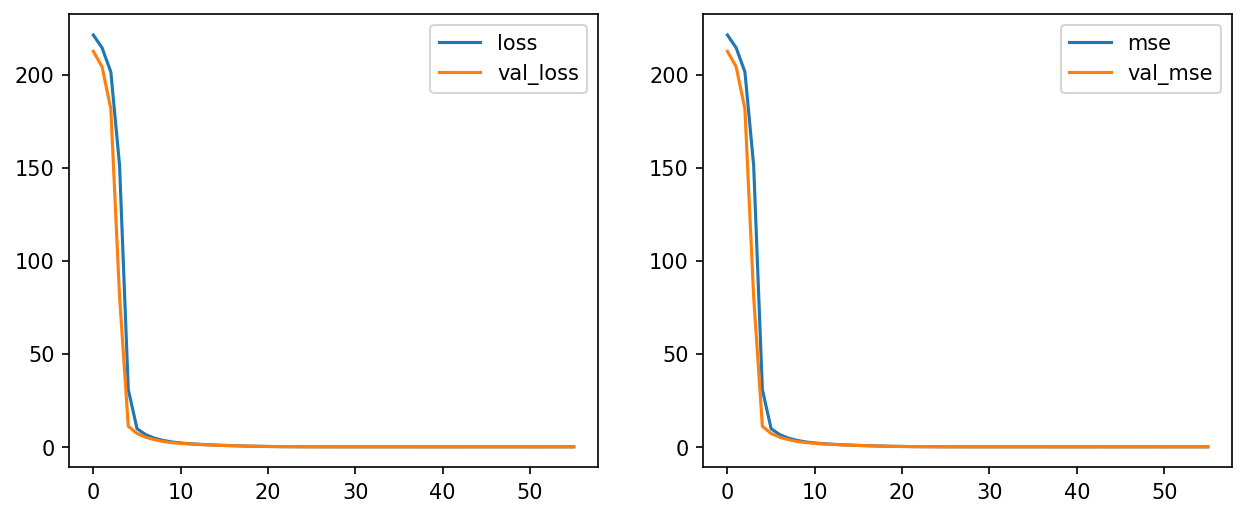

,loss,mse,val_loss,val_mse,epoch
51,0.086188,0.086188,0.080987,0.080987,51
52,0.090711,0.090711,0.091527,0.091527,52
53,0.086731,0.086731,0.085422,0.085422,53
54,0.086913,0.086913,0.082686,0.082686,54
55,0.087510,0.087510,0.101190,0.101190,55


In [19]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [20]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [21]:
yhat = model.predict(X_test, verbose=1)
rms = [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

10/10 [==============================] - 0s 1ms/step
[[21.001719]
 [16.715609]
 [16.378654]
 [19.681747]
 [ 7.991546]]


[0.31810299249074997]

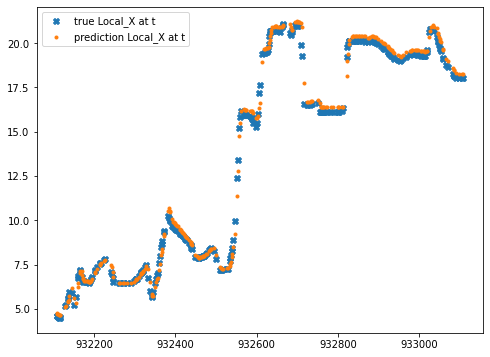

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(y_test.index,y_test, label = "true Local_X at t",marker = 'X', )
plt.scatter(y_test.index,yhat, label = "prediction Local_X at t",marker = '.')
plt.legend()
plt.show()

# Model 2

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 2|Add multi output time steps|1|1|1|0|4|**2**|

## Data preparation

We will use the same data set as model 1

In [23]:
n_steps = 4
n_labels = 1
n_future = 2
n_features = 1

In [24]:
X, y = series2seq1(simple_df.Local_X, n_in=n_steps, n_out=n_future, dropnan=True)
print(X.head(), X.shape)
print(y.head(), y.shape)

        Local_X(t-4)  Local_X(t-3)  Local_X(t-2)  Local_X(t-1)
932106      4.725434      4.694650      4.668727      4.646575
932107      4.694650      4.668727      4.646575      4.627103
932108      4.668727      4.646575      4.627103      4.609221
932109      4.646575      4.627103      4.609221      4.591890
932110      4.627103      4.609221      4.591890      4.571389 (1005, 4)
        Local_X(t)  Local_X(t+1)
932106    4.627103      4.609221
932107    4.609221      4.591890
932108    4.591890      4.571389
932109    4.571389      4.543895
932110    4.543895      4.515965 (1005, 2)


### Split the data set


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(703, 4) (302, 4) (703, 2) (302, 2)


In [26]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(703, 4)


,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1)
count,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02
mean,-3.787077e-16,-1.895118e-17,2.337312e-17,7.615214e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.575110e+00,-1.578736e+00,-1.580849e+00,-1.585490e+00
25%,-1.067267e+00,-1.067488e+00,-1.073312e+00,-1.077957e+00
50%,4.144181e-01,4.130314e-01,4.118561e-01,4.104574e-01
75%,9.633450e-01,9.625659e-01,9.618094e-01,9.610258e-01
max,1.268899e+00,1.268625e+00,1.268315e+00,1.267863e+00


### Reshape data sets


In [27]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [28]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 14ms/step - loss: 219.5254 - mse: 219.5254 - val_loss: 212.3854 - val_mse: 212.3854
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 213.2573 - mse: 213.2573 - val_loss: 203.0655 - val_mse: 203.0655
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 193.3549 - mse: 193.3549 - val_loss: 162.3588 - val_mse: 162.3588
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 97.7350 - mse: 97.7350 - val_loss: 39.9566 - val_mse: 39.9566
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 33.0723 - mse: 33.0723 - val_loss: 20.9677 - val_mse: 20.9677
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 12.8090 - mse: 12.8090 - val_loss: 8.8973 - val_mse: 8.8973
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 7.5265 - mse: 7.5265 - val_loss: 5.5191 - val_mse: 5.5191
Epoch 8/100
22/22 [=============================

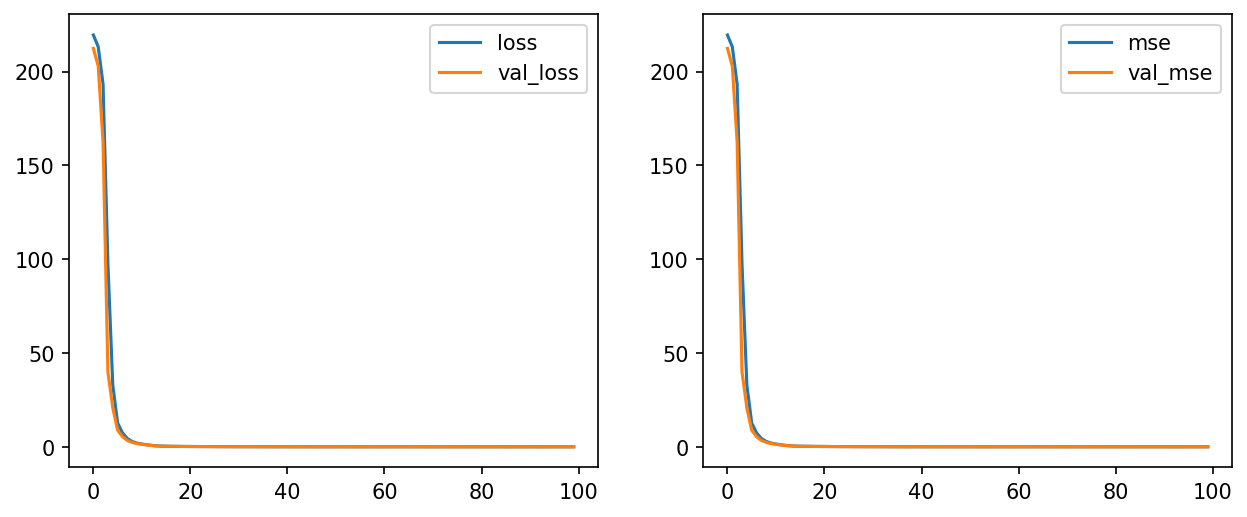

,loss,mse,val_loss,val_mse,epoch
95,0.100392,0.100392,0.111835,0.111835,95
96,0.103050,0.103050,0.110145,0.110145,96
97,0.104543,0.104543,0.100563,0.100563,97
98,0.109265,0.109265,0.101291,0.101291,98
99,0.108251,0.108251,0.125830,0.125830,99


In [29]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [30]:
yhat = model.predict(X_test, verbose=1)
rms += [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

10/10 [==============================] - 0s 2ms/step
[[20.512938  20.481354 ]
 [16.445215  16.516975 ]
 [16.049189  16.132568 ]
 [19.194313  19.196644 ]
 [ 7.960776   7.9825234]]


[0.31810299249074997, 0.3547247337248267]

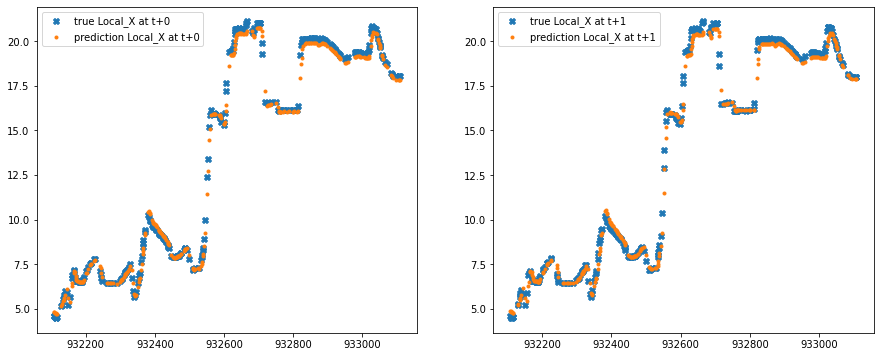

In [31]:
plt.figure(figsize=(15,6))
for i in range(n_future):
  plt.subplot(1,n_future,i+1)
  plt.scatter(y_test.index,y_test.iloc[:,i], label = "true Local_X at t+{}".format(i),marker = 'X', )
  plt.scatter(y_test.index,yhat[:,i], label = "prediction Local_X at t+{}".format(i),marker = '.')
  plt.legend()
plt.show()

# Model 3

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 3|Add multi input series|1|**2**|1|0|4|2|

## Data preparation

We will add one more feature v_Vel to the data set used in model 1 and 2

In [32]:
n_steps = 4
n_future = 2
n_features = 2
feature_names = ['Local_X','v_Vel']
target_names = ['Local_X']
n_labels = len(target_names)
n_features = len(feature_names)

### series2seq2: Function that return sequence input and output| Version 2

**Arguments**:

- data: Sequence of observations as a list or NumPy array.
- n_in: Number of lag observations as input (X).
- n_out: Number of observations as output (y).
- **labels**: name of target variables
- dropnan: Boolean whether or not to drop rows with NaN values.
    
**Returns**:
- X: Feature Pandas DataFrame
- y: Label Pandas dataframe

  

In [33]:
def series2seq2(data, n_in=1, n_out=1,labels=None, dropnan=True):

    dat = data.copy()
    if isinstance(dat,pd.Series):
      features = [dat.name]
      targets = [dat.name]
    else:
      features = dat.columns
      if labels == None:
        targets = dat.columns
      else:
        targets = labels
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dat.shift(i))
        names += ['{}(t-{})'.format(j, i) for j in features ]
    # forecast sequence (t, t+1, ... t+n) for selected labels
    for i in range(0, n_out):
        cols.append(dat[targets].shift(-i))
        if i == 0:
            names += ['{}(t)'.format(j) for j in targets]
        else:
            names += ['{}(t+{})'.format(j, i) for j in targets]
    # put it all together
    agg = pd.concat(cols, axis=1)
    
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    X = agg.iloc[:,:len(features)*n_in]
    y = agg.iloc[:,len(features)*n_in:].copy()
    print(X.head(), X.shape)
    print(y.head(), y.shape)
    return X, y
  
# Test the function
X, y = series2seq2(df[feature_names], n_in=2, n_out=1,labels = target_names, dropnan=False)

   Local_X(t-2)  v_Vel(t-2)  Local_X(t-1)  v_Vel(t-1)
0           NaN         NaN           NaN         NaN
1           NaN         NaN     16.467196   40.000000
2     16.467196   40.000000     16.446594   40.012349
3     16.446594   40.012349     16.425991   39.999855
4     16.425991   39.999855     16.405392   39.992920 (1048575, 4)
   Local_X(t)
0   16.467196
1   16.446594
2   16.425991
3   16.405392
4   16.384804 (1048575, 1)


In [34]:
X, y = series2seq2(simple_df[feature_names], n_in=n_steps, n_out=n_future,labels = target_names, dropnan=True)

        Local_X(t-4)  v_Vel(t-4)  ...  Local_X(t-1)  v_Vel(t-1)
932106      4.725434   45.030000  ...      4.646575   45.187921
932107      4.694650   44.490366  ...      4.627103   45.298705
932108      4.668727   44.918464  ...      4.609221   45.250796
932109      4.646575   45.187921  ...      4.591890   44.961476
932110      4.627103   45.298705  ...      4.571389   44.518607

[5 rows x 8 columns] (1005, 8)
        Local_X(t)  Local_X(t+1)
932106    4.627103      4.609221
932107    4.609221      4.591890
932108    4.591890      4.571389
932109    4.571389      4.543895
932110    4.543895      4.515965 (1005, 2)


### Split the data set


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(703, 8) (302, 8) (703, 2) (302, 2)


In [36]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(703, 8)


,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1)
count,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02
mean,-3.787077e-16,1.285013e-15,-1.895118e-17,-4.460435e-16,2.337312e-17,1.166682e-16,7.615214e-16,-2.524652e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.575110e+00,-1.665909e+00,-1.578736e+00,-1.667918e+00,-1.580849e+00,-1.670630e+00,-1.585490e+00,-1.674027e+00
25%,-1.067267e+00,-8.310449e-01,-1.067488e+00,-8.350406e-01,-1.073312e+00,-8.327188e-01,-1.077957e+00,-8.338836e-01
50%,4.144181e-01,1.120130e-02,4.130314e-01,1.268329e-02,4.118561e-01,1.284191e-02,4.104574e-01,1.399114e-02
75%,9.633450e-01,8.446867e-01,9.625659e-01,8.477701e-01,9.618094e-01,8.511755e-01,9.610258e-01,8.547545e-01
max,1.268899e+00,2.124380e+00,1.268625e+00,2.126754e+00,1.268315e+00,2.127984e+00,1.267863e+00,2.144042e+00


### Reshape data sets


In [37]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [38]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 17ms/step - loss: 218.6739 - mse: 218.6739 - val_loss: 209.1932 - val_mse: 209.1932
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 198.3735 - mse: 198.3735 - val_loss: 132.8519 - val_mse: 132.8519
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 70.2554 - mse: 70.2554 - val_loss: 48.0716 - val_mse: 48.0716
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 40.9709 - mse: 40.9709 - val_loss: 33.1634 - val_mse: 33.1634
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 29.3135 - mse: 29.3135 - val_loss: 23.7289 - val_mse: 23.7289
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 21.0163 - mse: 21.0163 - val_loss: 19.1759 - val_mse: 19.1759
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 14.2063 - mse: 14.2063 - val_loss: 12.3509 - val_mse: 12.3509
Epoch 8/100
22/22 [===========================

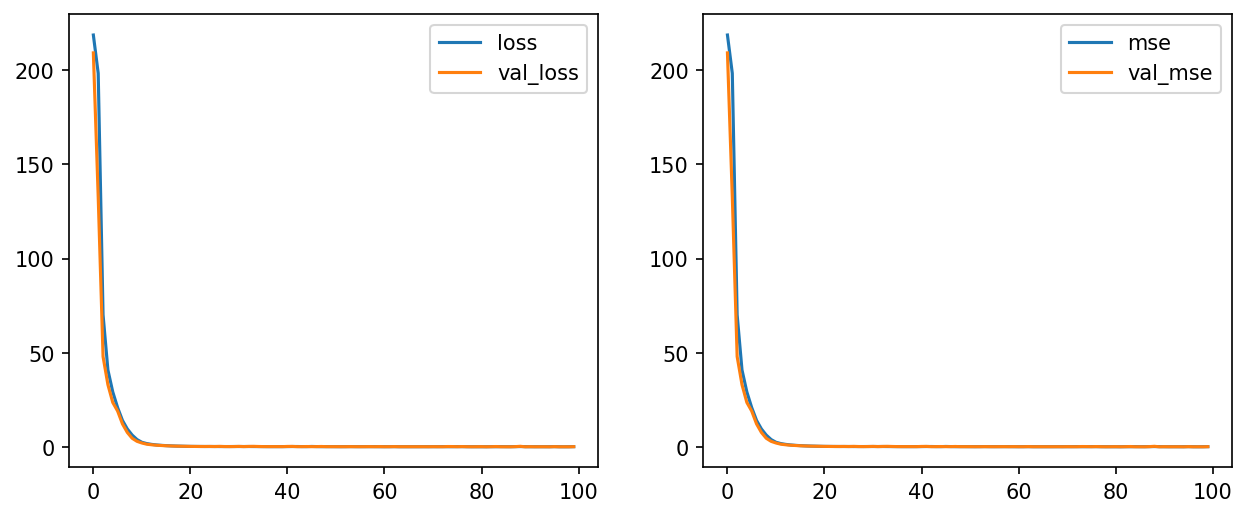

,loss,mse,val_loss,val_mse,epoch
95,0.289255,0.289255,0.291023,0.291023,95
96,0.241897,0.241897,0.205528,0.205528,96
97,0.219575,0.219575,0.226874,0.226874,97
98,0.246345,0.246345,0.193983,0.193983,98
99,0.281513,0.281513,0.277673,0.277673,99


In [39]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [40]:
yhat = model.predict(X_test, verbose=1)
rms += [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

10/10 [==============================] - 0s 2ms/step
[[21.261696 21.262363]
 [16.94269  16.917667]
 [16.740871 16.713097]
 [19.846342 19.877695]
 [ 8.191774  8.189618]]


[0.31810299249074997, 0.3547247337248267, 0.5269472090785062]

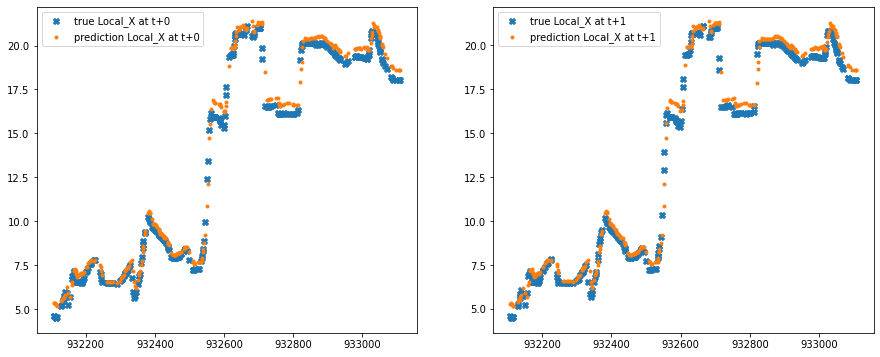

In [41]:
plt.figure(figsize=(15,6))
k = 1
for i in range(n_future):
  for j in range(1,n_labels+1):
    plt.subplot(j,n_future,k)
    plt.scatter(y_test.index,y_test.iloc[:,i], label = "true Local_X at t+{}".format(i),marker = 'X', )
    plt.scatter(y_test.index,yhat[:,i], label = "prediction Local_X at t+{}".format(i),marker = '.')
    plt.legend()
    k+=1
plt.show()

# Model 4

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 4|Add multi `output` series|1|2|**2**|0|4|2|

## Data preparation

We will use the same dataset of model 3

In [42]:
n_steps = 4
n_future = 2
n_features = 2
feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
n_features = len(feature_names)

In [43]:
X, y = series2seq2(simple_df[feature_names], n_in=n_steps, n_out=n_future,labels = target_names, dropnan=True)

        Local_X(t-4)  v_Vel(t-4)  ...  Local_X(t-1)  v_Vel(t-1)
932106      4.725434   45.030000  ...      4.646575   45.187921
932107      4.694650   44.490366  ...      4.627103   45.298705
932108      4.668727   44.918464  ...      4.609221   45.250796
932109      4.646575   45.187921  ...      4.591890   44.961476
932110      4.627103   45.298705  ...      4.571389   44.518607

[5 rows x 8 columns] (1005, 8)
        Local_X(t)   v_Vel(t)  Local_X(t+1)  v_Vel(t+1)
932106    4.627103  45.298705      4.609221   45.250796
932107    4.609221  45.250796      4.591890   44.961476
932108    4.591890  44.961476      4.571389   44.518607
932109    4.571389  44.518607      4.543895   44.002607
932110    4.543895  44.002607      4.515965   43.534859 (1005, 4)


### Split the data set


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(703, 8) (302, 8) (703, 4) (302, 4)


In [45]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(703, 8)


,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1)
count,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02
mean,-3.787077e-16,1.285013e-15,-1.895118e-17,-4.460435e-16,2.337312e-17,1.166682e-16,7.615214e-16,-2.524652e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.575110e+00,-1.665909e+00,-1.578736e+00,-1.667918e+00,-1.580849e+00,-1.670630e+00,-1.585490e+00,-1.674027e+00
25%,-1.067267e+00,-8.310449e-01,-1.067488e+00,-8.350406e-01,-1.073312e+00,-8.327188e-01,-1.077957e+00,-8.338836e-01
50%,4.144181e-01,1.120130e-02,4.130314e-01,1.268329e-02,4.118561e-01,1.284191e-02,4.104574e-01,1.399114e-02
75%,9.633450e-01,8.446867e-01,9.625659e-01,8.477701e-01,9.618094e-01,8.511755e-01,9.610258e-01,8.547545e-01
max,1.268899e+00,2.124380e+00,1.268625e+00,2.126754e+00,1.268315e+00,2.127984e+00,1.267863e+00,2.144042e+00


### Reshape data sets


In [46]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [47]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 15ms/step - loss: 373.7903 - mse: 373.7903 - val_loss: 418.7645 - val_mse: 418.7645
Epoch 2/100
22/22 [==============================] - 0s 6ms/step - loss: 353.3907 - mse: 353.3907 - val_loss: 338.1276 - val_mse: 338.1276
Epoch 3/100
22/22 [==============================] - 0s 6ms/step - loss: 146.9411 - mse: 146.9411 - val_loss: 103.8713 - val_mse: 103.8713
Epoch 4/100
22/22 [==============================] - 0s 6ms/step - loss: 79.5960 - mse: 79.5960 - val_loss: 87.7487 - val_mse: 87.7487
Epoch 5/100
22/22 [==============================] - 0s 6ms/step - loss: 69.5022 - mse: 69.5022 - val_loss: 72.8973 - val_mse: 72.8973
Epoch 6/100
22/22 [==============================] - 0s 6ms/step - loss: 63.7572 - mse: 63.7572 - val_loss: 68.9629 - val_mse: 68.9629
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 59.4299 - mse: 59.4299 - val_loss: 62.8469 - val_mse: 62.8469
Epoch 8/100
22/22 [=======================

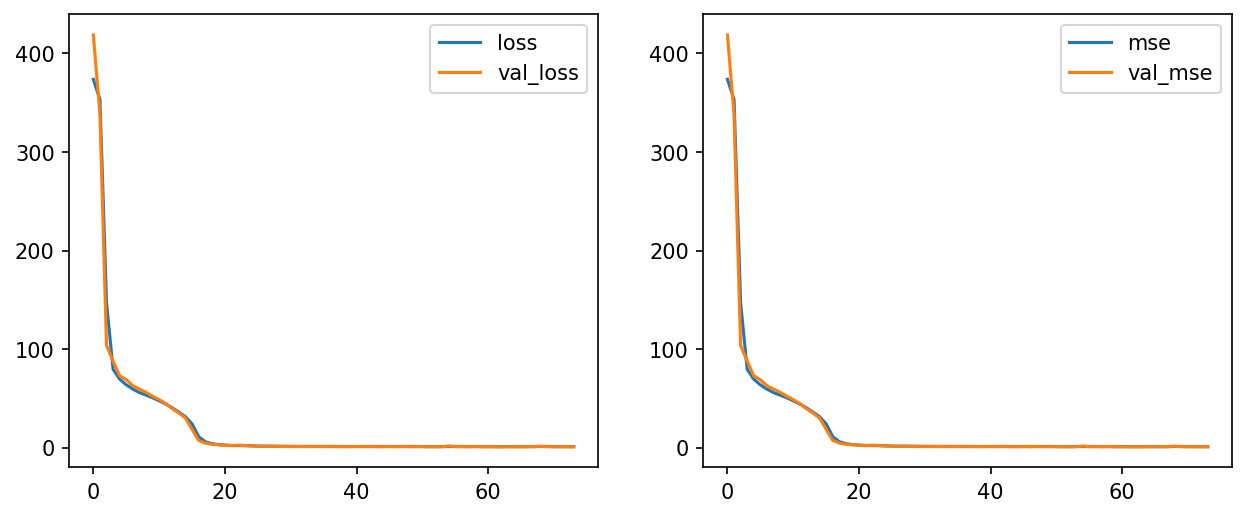

,loss,mse,val_loss,val_mse,epoch
69,1.150983,1.150983,1.090208,1.090208,69
70,1.136064,1.136064,0.898216,0.898216,70
71,1.067433,1.067433,0.976985,0.976985,71
72,1.032935,1.032935,0.874351,0.874351,72
73,1.042204,1.042204,0.884540,0.884540,73


In [48]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [49]:
yhat = model.predict(X_test, verbose=1)
rms += [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

10/10 [==============================] - 0s 2ms/step
[[21.41736   20.78816   21.373875  20.877455 ]
 [16.581621   9.652153  16.593037   9.624949 ]
 [16.33635    1.242728  16.474157   1.4567192]
 [19.24092   34.55029   19.179878  34.237465 ]
 [ 7.8975034 29.383768   7.9592547 29.560043 ]]


[0.31810299249074997,
 0.3547247337248267,
 0.5269472090785062,
 0.9404996127354541]

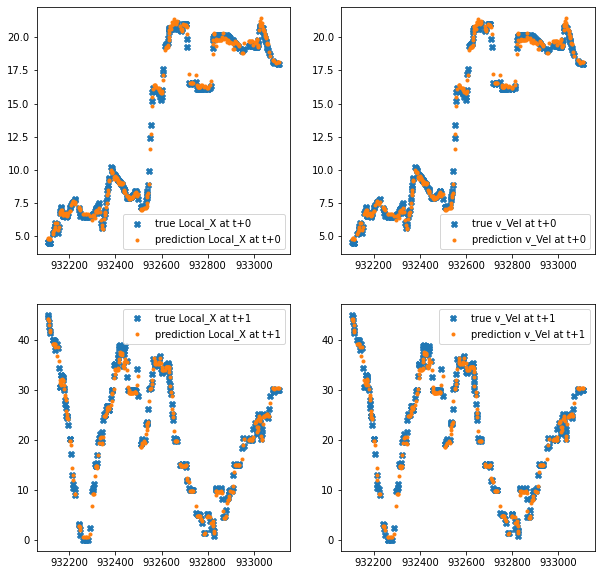

In [50]:
plt.figure(figsize=(n_labels*5,n_future*5))
k = 1
for i in range(n_future):
  for j in range(1,n_labels+1):
    plt.subplot(n_labels,n_future,k)
    plt.scatter(y_test.index,y_test.iloc[:,i], label = "true {} at t+{}".format(target_names[j-1],i),marker = 'X', )
    plt.scatter(y_test.index,yhat[:,i], label = "prediction {} at t+{}".format(target_names[j-1],i),marker = '.')
    plt.legend()
    k+=1
plt.show()

# Model 5

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 5|Add multi constant input|1|2|2|**2**|4|2|

## Data preparation

We will add one two constant features `v_Length`, `v_Width` to the data set used in model 3 and 4

In [51]:
simple_df[[ 'Local_X', 'v_Vel', 'v_Length', 'v_Width']].head()

,Local_X,v_Vel,v_Length,v_Width
932102,4.725434,45.030000,18.5,6.9
932103,4.694650,44.490366,18.5,6.9
932104,4.668727,44.918464,18.5,6.9
932105,4.646575,45.187921,18.5,6.9
932106,4.627103,45.298705,18.5,6.9


In [52]:
n_steps = 4
n_future = 2
n_features = 2
series_feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
n_features = len(feature_names)
const_feats = []

### series2seq3: Function that return sequence input and output| Version 3

**Arguments**:

- data: Sequence of observations as a list or NumPy array.
- n_in: Number of lag observations as input (X).
- n_out: Number of observations as output (y).
- **series_features**: names of series features
- labels: name of target variables
- dropnan: Boolean whether or not to drop rows with NaN values.
    
**Returns**:
- X: Feature Pandas DataFrame
- y: Label Pandas dataframe

  

In [53]:
def series2seq3(data, n_in=1, n_out=1,labels=None,series_features=None, dropnan=True):

    dat = data.copy()
    # check if the data set is univariable
    if isinstance(dat,pd.Series):
      features = [dat.name]
      targets = [dat.name]
    else:
      features = dat.columns
      if labels == None:
        targets = dat.columns
      else:
        targets = labels
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    if series_features == None:
      for i in range(n_in, 0, -1):
        cols.append(dat.shift(i))
        names += ['{}(t-{})'.format(j, i) for j in features ]
    else:
      for i in range(n_in, 0, -1):
        cols.append(dat[series_features].shift(i))
        names += ['{}(t-{})'.format(j, i) for j in series_features]
    # forecast sequence (t, t+1, ... t+n) for selected labels
    #print(targets)
    for i in range(0, n_out):
        cols.append(dat[targets].shift(-i))
        if i == 0:
            names += ['{}(t)'.format(j) for j in targets]
        else:
            names += ['{}(t+{})'.format(j, i) for j in targets]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # concatenate with constant features
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    X = agg.iloc[:,:len(series_features)*n_in]
    X = pd.concat([X,dat.drop(columns=series_features)], axis=1).dropna()
    y = agg.iloc[:,len(series_features)*n_in:].copy()
    #print(X.head(), X.shape)
    #print(y.head(), y.shape)
    return X, y
  
# Test the function
X, y = series2seq3(simple_df[[ 'Local_X', 'v_Vel', 'v_Length', 'v_Width']], n_in=2, n_out=1,labels = target_names,series_features=series_feature_names, dropnan=True)

In [54]:
X, y = series2seq3(simple_df[[ 'Local_X', 'v_Vel', 'v_Length', 'v_Width']], 
                   n_in=n_steps, n_out=n_future,
                   labels = target_names,
                   series_features=series_feature_names, 
                   dropnan=True)

### Split the data set


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(703, 10) (302, 10) (703, 4) (302, 4)


In [56]:
X_train.describe()

,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),v_Length,v_Width
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.0,7.030000e+02
mean,13.692287,19.909697,13.702620,19.889630,13.712993,19.873644,13.723632,19.861151,18.5,6.900000e+00
std,5.846486,11.951255,5.839603,11.924824,5.832852,11.895896,5.826538,11.864298,0.0,3.555243e-15
min,4.483431,0.000000,4.483431,0.000000,4.492133,0.000000,4.485713,0.000000,18.5,6.900000e+00
25%,7.452526,9.977668,7.468915,9.931918,7.452526,9.967708,7.442872,9.967708,18.5,6.900000e+00
50%,16.115177,20.043566,16.114559,20.040876,16.115289,20.026410,16.115177,20.027146,18.5,6.900000e+00
75%,19.324471,30.004763,19.323622,29.999140,19.323085,29.999140,19.323085,30.002212,18.5,6.900000e+00
max,21.110886,45.298705,21.110886,45.250796,21.110886,45.187921,21.110886,45.298705,18.5,6.900000e+00


### Reshape data sets


In [57]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [58]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 16ms/step - loss: 195.7643 - mse: 195.7643 - val_loss: 80.5541 - val_mse: 80.5541
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: 46.8915 - mse: 46.8915 - val_loss: 36.5961 - val_mse: 36.5961
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: 28.3888 - mse: 28.3888 - val_loss: 20.3750 - val_mse: 20.3750
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: 14.6657 - mse: 14.6657 - val_loss: 12.6229 - val_mse: 12.6229
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: 8.5975 - mse: 8.5975 - val_loss: 5.5380 - val_mse: 5.5380
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: 3.4284 - mse: 3.4284 - val_loss: 2.2434 - val_mse: 2.2434
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: 1.8400 - mse: 1.8400 - val_loss: 1.3051 - val_mse: 1.3051
Epoch 8/100
22/22 [==============================] - 0s 7ms/step

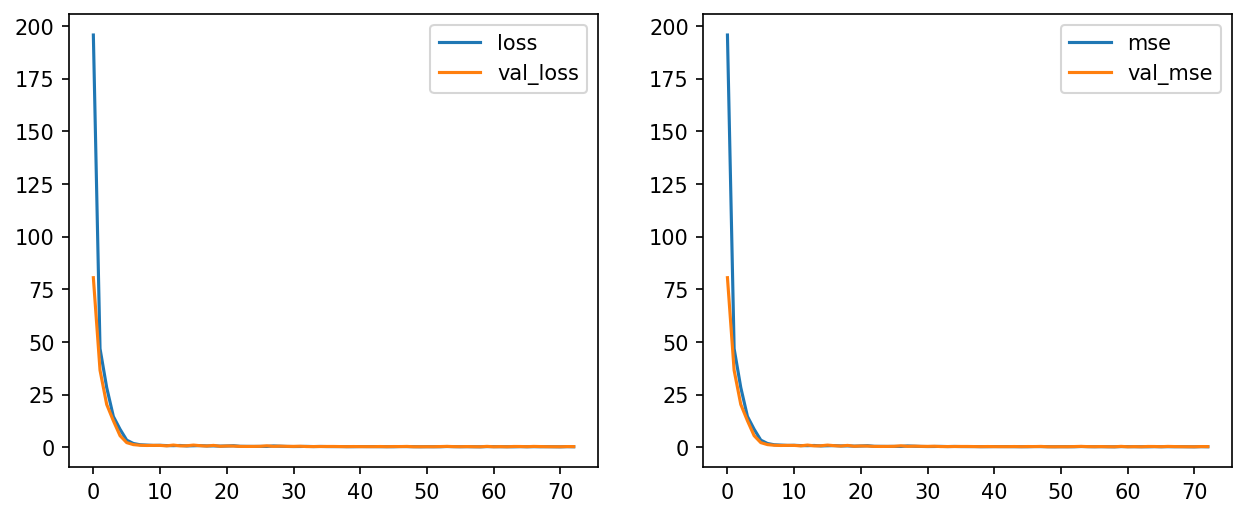

,loss,mse,val_loss,val_mse,epoch
68,0.318620,0.318620,0.314717,0.314717,68
69,0.287119,0.287119,0.296664,0.296664,69
70,0.254501,0.254501,0.281108,0.281108,70
71,0.329620,0.329620,0.377622,0.377622,71
72,0.280653,0.280653,0.361930,0.361930,72


In [59]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [60]:
yhat = model.predict(X_test, verbose=1)
rms += [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

10/10 [==============================] - 0s 2ms/step
[[20.946024   19.038256   20.659082   18.868324  ]
 [16.453629    9.57527    16.723633    9.412409  ]
 [15.651392    0.30688304 15.791513    0.24632406]
 [19.302685   34.460392   19.27286    34.62147   ]
 [ 7.925308   29.452866    8.105186   29.312014  ]]


[0.31810299249074997,
 0.3547247337248267,
 0.5269472090785062,
 0.9404996127354541,
 0.6016061918176122]

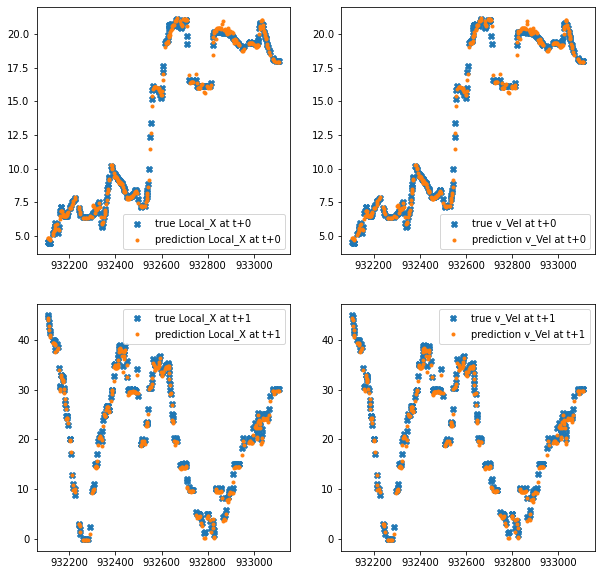

In [61]:
plt.figure(figsize=(n_labels*5,n_future*5))
k = 1
for i in range(n_future):
  for j in range(1,n_labels+1):
    plt.subplot(n_labels,n_future,k)
    plt.scatter(y_test.index,y_test.iloc[:,i], label = "true {} at t+{}".format(target_names[j-1],i),marker = 'X', )
    plt.scatter(y_test.index,yhat[:,i], label = "prediction {} at t+{}".format(target_names[j-1],i),marker = '.')
    plt.legend()
    k+=1
plt.show()

# Model 6

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|
Model 6|Add more objects|**4**|2|2|2|4|2|

## Data preparation

We will add 3 more objects to the dataset used in previous models

In [62]:
np.random.seed(23)
veh_list = np.random.choice(df.Vehicle_ID.unique(),3)
veh_list = np.append(veh_list,2582)
veh_list

array([ 950, 1116, 1537, 2582])

In [63]:
kept_cols = [ 'Vehicle_ID', 'Frame_ID','Local_X', 'v_Vel', 'v_Length', 'v_Width']
simple_df = df[df.Vehicle_ID.isin(veh_list)].copy()[kept_cols]
simple_df.info()
simple_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2533 entries, 267349 to 933111
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Vehicle_ID  2533 non-null   int64  
 1   Frame_ID    2533 non-null   int64  
 2   Local_X     2533 non-null   float64
 3   v_Vel       2533 non-null   float64
 4   v_Length    2533 non-null   float64
 5   v_Width     2533 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 138.5 KB


,Vehicle_ID,Frame_ID,Local_X,v_Vel,v_Length,v_Width
267349,950,2262,15.041098,53.370000,13.5,7.4
267350,950,2263,15.011664,52.976132,13.5,7.4
267351,950,2264,14.984828,53.498832,13.5,7.4
267352,950,2265,14.959791,53.781457,13.5,7.4
267353,950,2266,14.935760,53.823998,13.5,7.4


In [64]:
n_steps = 4
n_future = 2
n_features = 2
series_feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
n_features = len(feature_names)

### `treatment_cars` Function to prepare the data set for each car

In [65]:
def treatment_cars(data, n_in=1, n_out=1,labels=None,series_features=None):
  veh_ids = data.Vehicle_ID.unique()
  dat_X, dat_y = pd.DataFrame(),pd.DataFrame()

  for id in veh_ids:
    dat = data[data.Vehicle_ID==id].copy()
    X, y = series2seq3(dat.drop(columns=['Frame_ID']), n_in=n_in, n_out=n_out,labels = labels,series_features=series_features, dropnan=True)
    dat_X = pd.concat([dat_X,X],ignore_index=True)
    dat_y = pd.concat([dat_y,y],ignore_index=True)
  print(dat_X.shape)
  print(dat_y.shape)
  return dat_X ,dat_y
treatment_cars(simple_df,n_in=2, n_out=1, labels = target_names,series_features=series_feature_names,)

(2525, 7)
(2525, 2)


(      Local_X(t-2)  v_Vel(t-2)  Local_X(t-1)  ...  Vehicle_ID  v_Length  v_Width
 0        15.041098   53.370000     15.011664  ...         950      13.5      7.4
 1        15.011664   52.976132     14.984828  ...         950      13.5      7.4
 2        14.984828   53.498832     14.959791  ...         950      13.5      7.4
 3        14.959791   53.781457     14.935760  ...         950      13.5      7.4
 4        14.935760   53.823998     14.911937  ...         950      13.5      7.4
 ...            ...         ...           ...  ...         ...       ...      ...
 2520     18.019897   30.026622     18.018277  ...        2582      18.5      6.9
 2521     18.018277   30.025459     18.016226  ...        2582      18.5      6.9
 2522     18.016226   30.024576     18.013967  ...        2582      18.5      6.9
 2523     18.013967   30.017141     18.011604  ...        2582      18.5      6.9
 2524     18.011604   30.006093     18.009238  ...        2582      18.5      6.9
 
 [2525 rows x 

In [66]:
X, y = treatment_cars(simple_df, 
                   n_in=n_steps, n_out=n_future,
                   labels = target_names,
                   series_features=series_feature_names)

(2513, 11)
(2513, 4)


In [67]:
X.Vehicle_ID.unique()

array([ 950, 1116, 1537, 2582])

### Split the data set


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(1759, 11) (754, 11) (1759, 4) (754, 4)


In [69]:
X_train.describe()

,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),Vehicle_ID,v_Length,v_Width
count,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000,1759.000000
mean,23.403145,33.093043,23.413247,33.119217,23.423497,33.148387,23.433784,33.179207,1756.224559,16.096646,6.284707
std,11.458531,15.596586,11.455950,15.624689,11.453360,15.659101,11.450649,15.699645,699.556254,2.801407,0.943886
min,4.483431,0.000000,4.483431,0.000000,4.483431,0.000000,4.483431,0.000000,950.000000,12.000000,5.000000
25%,16.120885,23.919022,16.122446,24.137966,16.121312,24.198014,16.122280,24.261827,1116.000000,13.500000,5.400000
50%,19.970967,34.961879,19.994394,34.947302,19.980168,34.945027,19.989862,34.940802,1537.000000,18.000000,6.900000
75%,30.072894,40.000220,30.060505,40.001513,30.063117,40.001541,30.072894,40.002380,2582.000000,18.500000,6.900000
max,43.743336,71.392647,43.733417,71.627632,43.743336,71.627632,43.743336,71.392647,2582.000000,18.500000,7.400000


In [70]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(1759, 11)


,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),Vehicle_ID,v_Length,v_Width
count,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03,1.759000e+03
mean,-1.608719e-15,4.298879e-16,1.622100e-16,1.036440e-15,-3.412090e-15,-1.693737e-16,5.876166e-16,-1.285372e-15,3.509289e-17,2.265890e-16,1.698177e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.651146e+00,-2.121813e+00,-1.652400e+00,-2.119672e+00,-1.653669e+00,-2.116877e+00,-1.654959e+00,-2.113373e+00,-1.152480e+00,-1.462353e+00,-1.361083e+00
25%,-6.355317e-01,-5.882070e-01,-6.364204e-01,-5.748115e-01,-6.375583e-01,-5.715765e-01,-6.385231e-01,-5.679988e-01,-9.151867e-01,-9.269079e-01,-9.373031e-01
50%,-2.995303e-01,1.198234e-01,-2.984347e-01,1.169997e-01,-3.006392e-01,1.147346e-01,-3.007621e-01,1.122060e-01,-3.133766e-01,6.794281e-01,6.518719e-01
75%,5.820771e-01,4.428647e-01,5.802450e-01,4.404757e-01,5.797093e-01,4.376467e-01,5.798020e-01,4.346068e-01,1.180428e+00,8.579098e-01,6.518719e-01
max,1.775113e+00,2.455640e+00,1.773766e+00,2.464588e+00,1.774138e+00,2.457309e+00,1.773659e+00,2.434032e+00,1.180428e+00,8.579098e-01,1.181597e+00


### Reshape data sets


In [71]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [72]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
55/55 [==============================] - 1s 10ms/step - loss: 896.0613 - mse: 896.0613 - val_loss: 456.3641 - val_mse: 456.3641
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 227.9757 - mse: 227.9757 - val_loss: 91.1729 - val_mse: 91.1729
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 74.6982 - mse: 74.6982 - val_loss: 69.0120 - val_mse: 69.0120
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 66.2449 - mse: 66.2449 - val_loss: 64.2539 - val_mse: 64.2539
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 63.7373 - mse: 63.7373 - val_loss: 60.5593 - val_mse: 60.5593
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 62.4091 - mse: 62.4091 - val_loss: 59.4459 - val_mse: 59.4459
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 60.8533 - mse: 60.8533 - val_loss: 57.6423 - val_mse: 57.6423
Epoch 8/100
55/55 [=============================

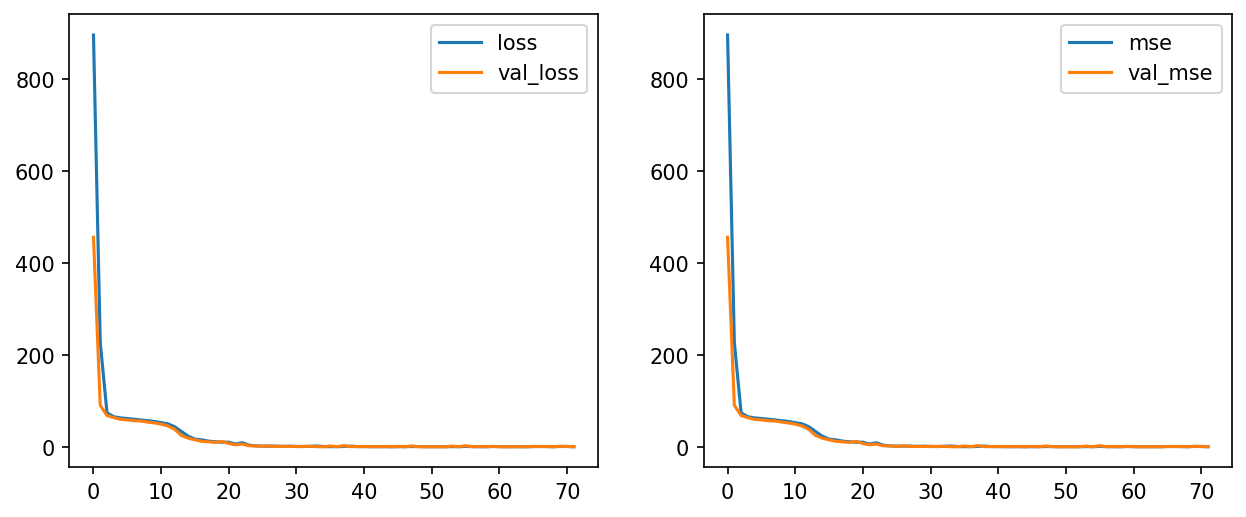

,loss,mse,val_loss,val_mse,epoch
67,1.514260,1.514260,1.445132,1.445132,67
68,1.161365,1.161365,1.064235,1.064235,68
69,1.733394,1.733394,1.966512,1.966512,69
70,1.589514,1.589514,1.723141,1.723141,70
71,1.277783,1.277783,1.006561,1.006561,71


In [73]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [74]:
yhat = model.predict(X_test, verbose=1)
rms += [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

24/24 [==============================] - 0s 2ms/step
[[41.610016 38.436623 41.67661  38.293404]
 [20.243391 67.51951  20.571625 67.138435]
 [29.787224 28.42877  29.581352 28.608438]
 [29.208332 38.480843 29.276987 38.452522]
 [17.334711 34.2337   17.286774 34.19419 ]]


[0.31810299249074997,
 0.3547247337248267,
 0.5269472090785062,
 0.9404996127354541,
 0.6016061918176122,
 1.0032750170456857]

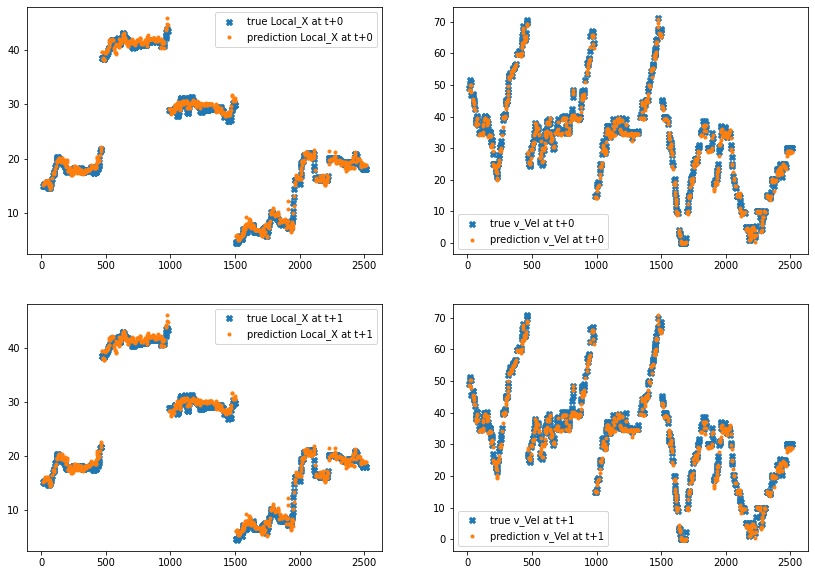

In [80]:
plt.figure(figsize=(n_labels*7,n_future*5))
k = 0
for i in range(n_future):
  for j in range(n_labels):
    plt.subplot(n_labels,n_future,k+1)
    plt.scatter(y_test.index,y_test.iloc[:,k], label = "true {} at t+{}".format(target_names[j],i),marker = 'X', )
    plt.scatter(y_test.index,yhat[:,k], label = "prediction {} at t+{}".format(target_names[j],i),marker = '.')
    plt.legend()
    k+=1
plt.show()

# 1000 cars



## Data preparation

We will add 3 more objects to the dataset used in previous models

In [ ]:
np.random.seed(23)
veh_list = np.random.choice(df.Vehicle_ID.unique(),1000)

In [ ]:
kept_cols = [ 'Vehicle_ID', 'Frame_ID','Local_X', 'v_Vel', 'v_Length', 'v_Width']
simple_df = df[df.Vehicle_ID.isin(veh_list)].copy()[kept_cols]
simple_df.info()
simple_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412788 entries, 1597 to 1048574
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Vehicle_ID  412788 non-null  int64  
 1   Frame_ID    412788 non-null  int64  
 2   Local_X     412788 non-null  float64
 3   v_Vel       412788 non-null  float64
 4   v_Length    412788 non-null  float64
 5   v_Width     412788 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 22.0 MB


,Vehicle_ID,Frame_ID,Local_X,v_Vel,v_Length,v_Width
1597,8,29,36.866364,45.000000,15.5,5.4
1598,8,30,36.843252,45.026327,15.5,5.4
1599,8,31,36.820189,45.005136,15.5,5.4
1600,8,32,36.797154,44.991848,15.5,5.4
1601,8,33,36.774126,44.986464,15.5,5.4


In [ ]:
n_steps = 4
n_future = 2
n_features = 2
series_feature_names = ['Local_X','v_Vel']
target_names = ['Local_X','v_Vel']
n_labels = len(target_names)
n_features = len(feature_names)

### `treatment_cars` Function to prepare the data set for each car

In [ ]:
def treatment_cars(data, n_in=1, n_out=1,labels=None,series_features=None):
  veh_ids = data.Vehicle_ID.unique()
  dat_X, dat_y = pd.DataFrame(),pd.DataFrame()

  for id in veh_ids:
    dat = data[data.Vehicle_ID==id].copy()
    X, y = series2seq3(dat.drop(columns=['Frame_ID']), n_in=n_in, n_out=n_out,labels = labels,series_features=series_features, dropnan=True)
    dat_X = pd.concat([dat_X,X],ignore_index=True)
    dat_y = pd.concat([dat_y,y],ignore_index=True)
  print(dat_X.shape)
  print(dat_y.shape)
  return dat_X ,dat_y
treatment_cars(simple_df,n_in=2, n_out=1, labels = target_names,series_features=series_feature_names,)

(411228, 7)
(411228, 2)


(        Local_X(t-2)  v_Vel(t-2)  Local_X(t-1)  ...  Vehicle_ID  v_Length  v_Width
 0          36.866364   45.000000     36.843252  ...           8      15.5      5.4
 1          36.843252   45.026327     36.820189  ...           8      15.5      5.4
 2          36.820189   45.005136     36.797154  ...           8      15.5      5.4
 3          36.797154   44.991848     36.774126  ...           8      15.5      5.4
 4          36.774126   44.986464     36.751084  ...           8      15.5      5.4
 ...              ...         ...           ...  ...         ...       ...      ...
 411223     55.006387   36.352110     55.080359  ...        2783      17.5      5.4
 411224     55.080359   35.757582     55.094042  ...        2783      17.5      5.4
 411225     55.094042   35.417817     55.092441  ...        2783      17.5      5.4
 411226     55.092441   35.221472     55.091506  ...        2783      17.5      5.4
 411227     55.091506   35.141983     55.107189  ...        2783      17.5  

In [ ]:
X, y = treatment_cars(simple_df, 
                   n_in=n_steps, n_out=n_future,
                   labels = target_names,
                   series_features=series_feature_names)

(408888, 11)
(408888, 4)


In [ ]:
len(X.Vehicle_ID.unique())

780

### Split the data set


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(286221, 11) (122667, 11) (286221, 4) (122667, 4)


In [ ]:
X_train.describe()

,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),Vehicle_ID,v_Length,v_Width
count,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000,286221.000000
mean,29.045081,38.441649,29.048139,38.477038,29.051298,38.512126,29.054547,38.547851,1526.353943,14.861266,6.232111
std,16.490716,14.080375,16.488574,14.104200,16.486557,14.127850,16.484656,14.151949,790.269066,4.672556,1.027438
min,1.532359,0.000000,1.512709,0.000000,1.512709,0.000000,1.526296,0.000000,8.000000,7.500000,2.900000
25%,17.258543,30.096309,17.266800,30.104983,17.273256,30.111966,17.282520,30.120365,905.000000,12.500000,5.400000
50%,29.360000,39.748517,29.364466,39.764313,29.367688,39.782257,29.371585,39.788468,1558.000000,14.500000,6.000000
75%,41.586056,47.773591,41.589212,47.868067,41.591834,47.950352,41.595455,48.024138,2214.000000,16.500000,6.900000
max,72.538231,99.712811,72.599378,99.712811,72.665101,99.712811,72.737734,99.712811,2783.000000,61.500000,8.500000


In [ ]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print(X_train.shape)
X_train.describe()

(703, 10)


,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),v_Length,v_Width
count,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,7.030000e+02,0.0,7.030000e+02
mean,-3.787077e-16,1.285013e-15,-1.895118e-17,-4.460435e-16,2.337312e-17,1.166682e-16,7.615214e-16,-2.524652e-15,NaN,9.992885e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN,7.665993e-15
min,-1.575110e+00,-1.665909e+00,-1.578736e+00,-1.667918e+00,-1.580849e+00,-1.670630e+00,-1.585490e+00,-1.674027e+00,NaN,9.992885e-01
25%,-1.067267e+00,-8.310449e-01,-1.067488e+00,-8.350406e-01,-1.073312e+00,-8.327188e-01,-1.077957e+00,-8.338836e-01,NaN,9.992885e-01
50%,4.144181e-01,1.120130e-02,4.130314e-01,1.268329e-02,4.118561e-01,1.284191e-02,4.104574e-01,1.399114e-02,NaN,9.992885e-01
75%,9.633450e-01,8.446867e-01,9.625659e-01,8.477701e-01,9.618094e-01,8.511755e-01,9.610258e-01,8.547545e-01,NaN,9.992885e-01
max,1.268899e+00,2.124380e+00,1.268625e+00,2.126754e+00,1.268315e+00,2.127984e+00,1.267863e+00,2.144042e+00,NaN,9.992885e-01


### Reshape data sets


In [ ]:
X_train = X_train.values
X_test = X_test.values
# reshape into [# samples, # timesteps,# features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_train.shape[1],1))

## Prediction model

In [ ]:
import time
time.time()

1599095362.8364496

In [ ]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(n_labels*n_future))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

start = time.time()
# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)
end = time.time()
'Training time was {} sec'.format(end-start)

Epoch 1/100
8945/8945 [==============================] - 65s 7ms/step - loss: 13.5191 - mse: 13.5191 - val_loss: 0.5706 - val_mse: 0.5706
Epoch 2/100
8945/8945 [==============================] - 62s 7ms/step - loss: 0.5832 - mse: 0.5832 - val_loss: 0.4684 - val_mse: 0.4684
Epoch 3/100
8945/8945 [==============================] - 63s 7ms/step - loss: 0.3798 - mse: 0.3798 - val_loss: 0.2995 - val_mse: 0.2995
Epoch 4/100
8945/8945 [==============================] - 62s 7ms/step - loss: 0.2918 - mse: 0.2918 - val_loss: 0.2735 - val_mse: 0.2735
Epoch 5/100
8945/8945 [==============================] - 62s 7ms/step - loss: 0.2210 - mse: 0.2210 - val_loss: 0.1712 - val_mse: 0.1712
Epoch 6/100
8945/8945 [==============================] - 61s 7ms/step - loss: 0.2163 - mse: 0.2163 - val_loss: 0.6358 - val_mse: 0.6358
Epoch 7/100
8945/8945 [==============================] - 61s 7ms/step - loss: 0.1992 - mse: 0.1992 - val_loss: 0.1389 - val_mse: 0.1389
Epoch 8/100
8945/8945 [=======================

'Training time was 2195.5686888694763 sec'

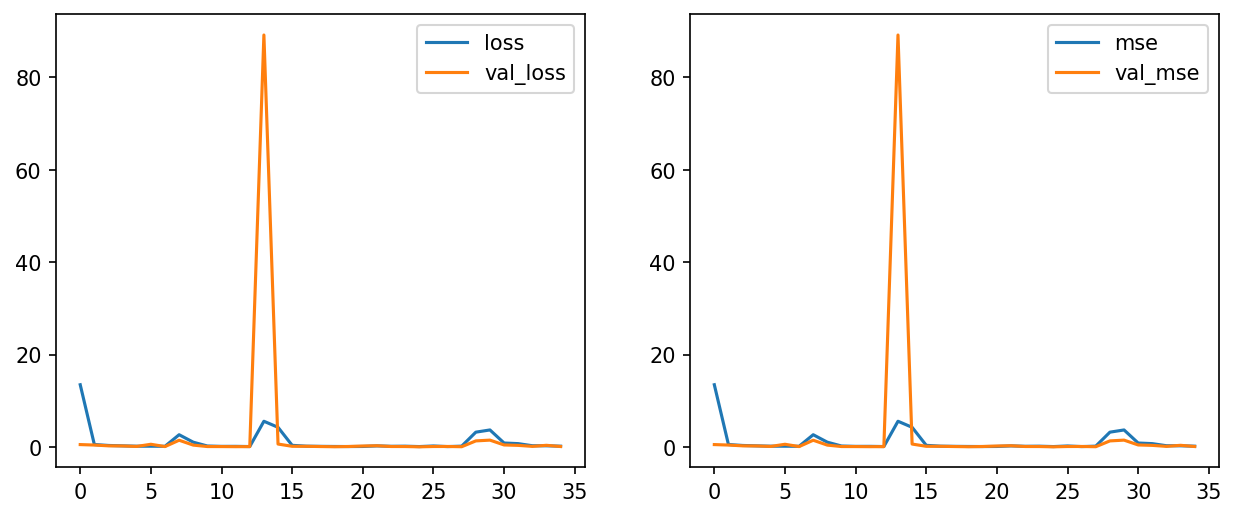

,loss,mse,val_loss,val_mse,epoch
30,0.907875,0.907875,0.489913,0.489913,30
31,0.775284,0.775284,0.399027,0.399027,31
32,0.319766,0.319766,0.181682,0.181682,32
33,0.307412,0.307412,0.410860,0.410860,33
34,0.223311,0.223311,0.148352,0.148352,34


In [ ]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()
hist.tail()

## Evaluation 


In [ ]:
yhat = model.predict(X_test, verbose=1)
rms += [sqrt(mean_squared_error(y_test, yhat))]
print(yhat[:5])
rms

3834/3834 [==============================] - 9s 2ms/step
[[17.994724  20.422564  17.998789  20.84313  ]
 [17.437428  38.920635  17.434309  38.92753  ]
 [ 6.732022  19.854837   6.7397003 20.120184 ]
 [39.02532   40.793602  39.024296  41.09278  ]
 [ 6.717615  56.268085   6.7091722 56.342472 ]]


[0.30731202053782647,
 0.3152044257917025,
 0.41217239780858556,
 0.8317798903576169,
 0.5861162059312589,
 0.7522358646201334,
 0.38516438587412954]

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


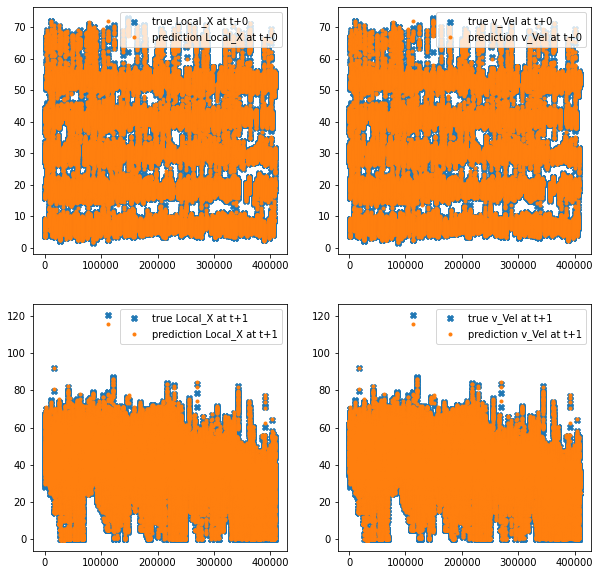

In [ ]:
plt.figure(figsize=(n_labels*5,n_future*5))
k = 1
for i in range(n_future):
  for j in range(1,n_labels+1):
    plt.subplot(n_labels,n_future,k)
    plt.scatter(y_test.index,y_test.iloc[:,i], label = "true {} at t+{}".format(target_names[j-1],i),marker = 'X', )
    plt.scatter(y_test.index,yhat[:,i], label = "prediction {} at t+{}".format(target_names[j-1],i),marker = '.')
    plt.legend()
    k+=1
plt.show()

# Conclusion

Overview on the performance of all simple models

|Model name|Description| # Car|# vars|# targets|# const_vars| # steps | # futures|RMS|Computing time|
|---|:--|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
Model 1|Baseline model with multi input time steps|1|1|1|0|**4**|1|0.307|0.1sec| 
Model 2|Add multi output time steps|1|1|1|0|4|**2**|0.315|0.1|
Model 3|Add multi input series|1|**2**|1|0|4|2|0.412|0.1|
Model 4|Add multi `output` series|1|2|**2**|0|4|2| 0.831|0.1|
Model 5|Add multi constant input|1|2|2|**2**|4|2|0.586|0.1|
Model 6|Add more objects|**4**|2|2|2|4|2|0.752|0.1
Model 6.1|Add much more objects|**1000**|2|2|2|4|2|0.385|2200sec (37min)

#END
